if not yet available some libraries have to be installed :<br>
- gmsh (best installed globally through package management system)
- python3 -m pip install pygmsh --user
- python3 -m pip install vtk --user

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from MeshedFields import *

/opt/pkg/devel/python/3.6.2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [20]:
mesh = MeshedField.CircularMesh(R=0.05, ratio=25.0, lcar=0.03)

print("%d points" % len(mesh.points))
print("%d triangles" % len(mesh.triangles))

117108 points
230862 triangles


The shape of a off-axis parabola follows a curve $z = \frac{r^2}{2 r_{fok}}$. $r_{fok}$ is the focal length of the parabola which is the distance of the (parallel) incidence axis of the beam and the rotational symmetry axis of the parabola (the z-axis). The distance from the parabola vertex to the focus is $r_{fok}/2$.<br>
We compute the parabolic shape in a local coordinate system centered at the intersection of the incidence axis with the shape. In this local coordinate system, the focus is placed at $[r_{fok},0,0]$ and the vertex of the parabola at $[r_{fok},0,r_{fok}/2]$. A parallel beam incident from $[0,0,-z]$ (propagating in z direction) is collected into the focus at $[r_{fok},0,0]$.

In [21]:
def parabola(p,rfok):
    """
    Move a point p along the z axis so that is lies on the surface
    of an off-axis parabola with focal length rfok.
    """
    x = rfok-p[0]
    y = p[1]
    r = np.sqrt(x*x+y*y)
    z = -(r*r/(2.0*rfok)-0.5*rfok)
    return np.array([p[0],p[1],z])

d = np.array([0.0, 0.0, 1.258])
pts = [parabola(p,0.1)+d for p in mesh.points]
para = MeshedField(pts, mesh.triangles)

In [22]:
para.BoundingBox()

((-0.050000000000000003, 0.050000000000000003),
 (-0.050000000000000003, 0.050000000000000003),
 (1.1955, 1.2955000000000001))

We check the typical size of the triangles in x and z direction.<br>
This has to be substantially smaller than the wavelength.

It does not show as expected because due to the surface curvature triangles at some y displacement from the axis are distorted. That's OK because for every triangle only one field trace is recorded and only the average spacing matters.

0.00135402686858
0.000296920589029


(array([   200.,   7240.,  16062.,  15561.,  13473.,  12424.,  11925.,
         11659.,  11279.,  11259.,  11129.,  10737.,  10685.,   9975.,
          9361.,   9054.,   8698.,   7772.,   7162.]),
 array([  0.00000000e+00,   2.63157895e-05,   5.26315789e-05,
          7.89473684e-05,   1.05263158e-04,   1.31578947e-04,
          1.57894737e-04,   1.84210526e-04,   2.10526316e-04,
          2.36842105e-04,   2.63157895e-04,   2.89473684e-04,
          3.15789474e-04,   3.42105263e-04,   3.68421053e-04,
          3.94736842e-04,   4.21052632e-04,   4.47368421e-04,
          4.73684211e-04,   5.00000000e-04]),
 <a list of 19 Patch objects>)

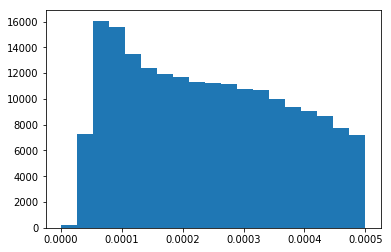

In [23]:
def zsize(id):
    t = para.triangles[id]
    pts = [para.points[ip] for ip in t]
    z = [p[2] for p in pts]
    dz = np.max(z)-np.min(z)
    return dz

def ysize(id):
    t = para.triangles[id]
    pts = [para.points[ip] for ip in t]
    y = [p[1] for p in pts]
    dy = np.max(y)-np.min(y)
    return dy

dy = [ysize(id) for id in range(para.Np)]
print(np.average(dy))
dz = [zsize(id) for id in range(para.Np)]
print(np.average(dz))

plt.hist(dz, bins=np.linspace(0,0.0005,20))

In [26]:
normals = para.MeshNormals()
print(np.sum(normals, axis=0)/para.Np)

[  6.79511927e-01   1.18062984e-04  -7.01189320e-01]


### setup the timing of the cells

The peak of the wave packet is assumed to start at the origin at t=0.

The start time of the traces is 300 steps before the expected time of arrival which is computed as the z coordinate of the observation point divided by the speed of light. The length is 800 steps what accounts for some propagation lines having greater length.

In [28]:
# time step
para.dt = 1.0e-13
para.Nt = 800
para.t0 = [p[2]/constants.c -300*para.dt for p in para.pos]
print(np.min(para.t0))
print(np.max(para.t0))
print(len(para.t0))

3.95788601633e-09
4.29126218711e-09
230862


## check geometry and write to file

In [19]:
para.ShowMeshedField(showCenters=False,showAxes=True)

estimated memory requirements

In [30]:
8*para.Np*para.Nt*6

8865100800

In [31]:
filename="Parabola.h5"
para.WriteMeshedField(filename)

## load file after propagation and analyze

In [ ]:
filename="../run/MeshGaussian.h5"
prop = MeshedField.ReadMeshedField(filename)

area = prop.MeshArea()
S = [np.linalg.norm(prop.EnergyFlowVector(i)) for i in range(prop.Np)]
Pz = [prop.NormalEnergyFlow(i) for i in range(prop.Np)]

print("peak energy density = %.6f J/m²" % np.max(S))
print("total pulse energy = %.1f µJ" % (1e6*np.dot(area,Pz)))

def pick(id):
    if id>0 and id<prop.Np:
        print("cell No. %d pos=%s" % (id,prop.pos[id]))
        print("pointing vector S=%s" % prop.EnergyFlowVector(id))
        prop.ShowFieldTrace(id)

prop.ShowMeshedField(scalars=Pz,scalarTitle="Pz",pickAction=pick,showGrid=False)